# Aj tak za to može Čína

- **Emise skleníkových plynů pod drobnohledem**
  - Jaké jsou skleníkové plyny
  - Přepočet na CO2eq -> jak moc do toho zabíhat?
  - 
- **Proč nedává smysl porovnávat emise SR a Číny? A kdy to smysl dává?**
  - Obdélníčky Čína vs SR - šířka = počet obyvatel, výška = emise na osobu
  - Srovnání s dalšími státy? Například pozice SK v rámci EU, následně srovnání EU s Čínou?
  - Doplnit, o kolik by se to změnilo při uvážení obchodu
  - Bylo by hezké mít historické emise...
- **Jak počítáme emise z jednotlivých sektorů hospodářství?**
  - Koláč? O té metodologii toho moc nevím...
- **Jak se dají emise snížit a komu se to už podařilo?**
  - Jak: Mitigační opatření podle IMF
  - Komu se podařilo: ?


# Data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc_file_defaults()
import world_bank_data as wb

In [ ]:
# POPULATION
pop_raw = wb.get_series('SP.POP.TOTL', id_or_value='id')
pop = pop_raw.reset_index().query('Year == "2015"')[['Country', 'SP.POP.TOTL']].rename(columns={'Country': 'code', 'SP.POP.TOTL': 'pop'})
pop = pop[np.isfinite(pop['pop'])]  # there are two countries with no population data
pop['pop'] = np.int_(pop['pop'])
pop = pop.sort_values('code').reset_index(drop=True)
pop.head()

In [ ]:
# GDP
gdp_raw = wb.get_series('NY.GDP.MKTP.PP.KD', id_or_value='id')
gdp = gdp_raw.reset_index().query('Year == "2015"')[['Country', 'NY.GDP.MKTP.PP.KD']] \
    .rename(columns={'Country': 'code', 'NY.GDP.MKTP.PP.KD': 'gdp'}) \
    .sort_values('code') \
    .reset_index(drop=True)
gdp.head()

In [ ]:
# GREENHOUSE GASES
ghgs = ['CO2', 'CH4', 'N2O']
edgar_files = ['CO2_excl_short-cycle_org_C', 'CH4', 'N2O']
edgar = None

for gas in ghgs:
    ef = 'CO2_excl_short-cycle_org_C' if gas == 'CO2' else gas
    ey = 2018 if gas == 'CO2' else 2015
    filename = f'../data/edgar/v5.0/v50_{ef}_1970_{ey}.xls'
    frame = pd.read_excel(filename, sheet_name='TOTALS BY COUNTRY', header=9)
    frame = frame[['ISO_A3'] + list(range(1970, ey + 1))].rename(columns={'ISO_A3': 'code'}).set_index('code')
    frame.columns = frame.columns.rename('year')
    frame = frame.unstack().rename(gas).reset_index()
    frame = frame[~frame['code'].isin(['SEA', 'AIR'])]
    if edgar is None:
        edgar = frame
    else:
        edgar = pd.merge(edgar, frame, how='outer')

ghg = edgar.query('year == 2015').drop(columns=['year']).sort_values('code').reset_index(drop=True)
ghg['ghg'] = ghg['CO2'] + 28 * ghg['CH4'] + 265 * ghg['N2O']
ghg.head()

In [ ]:
regions = pd.read_csv('../data/regions.csv', keep_default_na=False)[['code', 'region_B_en', 'continent_en']] \
    .rename(columns={'region_B_en': 'region', 'continent_en': 'continent'}) \
    .query('region != ""')

countries = pd.merge(regions, pop)
countries = pd.merge(countries, gdp)
countries = pd.merge(countries, ghg[['code', 'ghg']])

countries.head()

### This is enough

In [6]:
df = pd.read_csv('../data/world-emissions-2015.csv')

In [7]:
# make the units more sane - and create per capita and per gdp columns
df['ghg'] = df['ghg'] / 1e3  # in million tonnes (rather than in gigagrams, i.e. thousand tonnes)
df['gdp_per_capita'] = df['gdp'] / df['pop']
df['ghg_per_capita'] = 1e6 * df['ghg'] / df['pop']  # in tonnes per capita
df['ghg_per_gdp'] = 1e12 * df['ghg'] / df['gdp']  # in grams per dollar

In [8]:
regions = pd.read_csv('../data/regions.csv', keep_default_na=False)[['code', 'name_en', 'name_cz']]
df = pd.merge(df, regions)
df.head()

,code,region,continent,pop,gdp,ghg,gdp_per_capita,ghg_per_capita,ghg_per_gdp,name_en,name_cz
0,ABW,South/Latin America (others),South and Latin America,104341,3.889424e+09,1.000182,37276.080417,9.585708,257.154405,Aruba,Aruba
1,AFG,Asia B,Asia,34413603,7.614873e+10,32.756476,2212.750899,0.951847,430.164431,Afghanistan,Afghánistán
2,AGO,Africa (others),Africa,27884381,2.240904e+11,85.591020,8036.414092,3.069497,381.948569,Angola,Angola
3,ALB,Europe B,Europe,2880703,3.493121e+10,8.985267,12125.931481,3.119123,257.227490,Albania,Albánie
4,ARE,Middle East A,Asia,9262900,6.041152e+11,249.667673,65218.792273,26.953511,413.278284,United Arab Emirates,Spojené arabské emiráty


# Charts

In [ ]:
# zakladni srovnani SK vs China (SVK, CHN)

In [9]:
df = df.set_index('code')

In [76]:
svk = df.loc['SVK']
chn = df.loc['CHN']

svk_color = '#4591CE'
# chn_color = '#C32B2A'
chn_color = '#DF2407' # this is the Chinese flag color, but it's too bright

In [10]:
df.loc['SVK']

region                       Europe B
continent                      Europe
pop                           5423801
gdp               159750748291.707001
ghg                         43.448917
gdp_per_capita           29453.652207
ghg_per_capita               8.010787
ghg_per_gdp                271.979428
name_en                      Slovakia
name_cz                     Slovensko
Name: SVK, dtype: object

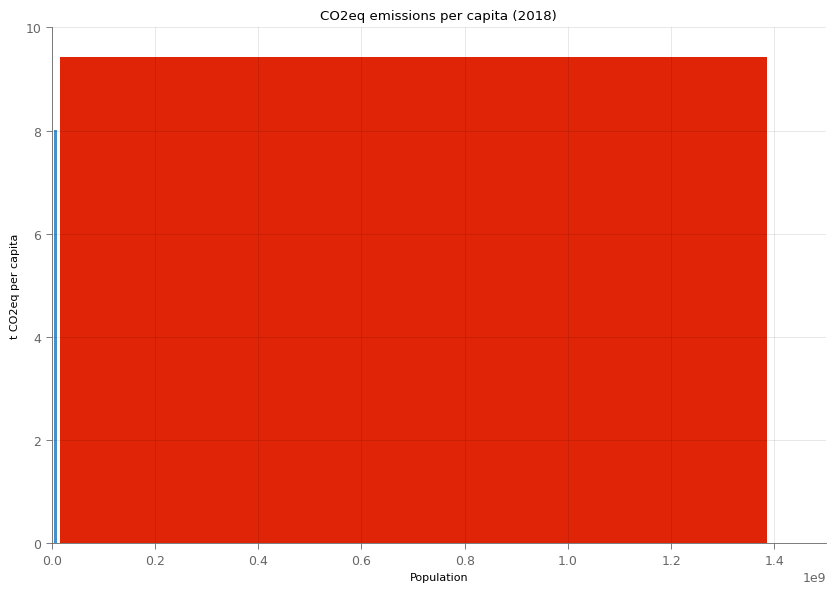

In [61]:
fig, ax = plt.subplots()

xgap = 5e6
# plt.text(x + 0.5 * row['pop'] - 4 * xgap, row['ghg_per_capita'] + ygap, row['country'], rotation=45, fontsize=9)
rec_svk = mpl.patches.Rectangle((xgap, 0), svk['pop'], svk['ghg_per_capita'], ec=None, fc=svk_color)
rec_chn = mpl.patches.Rectangle((2 * xgap + svk['pop'], 0), chn['pop'], chn['ghg_per_capita'], ec=None, fc=chn_color)
ax.add_patch(rec_svk)
ax.add_patch(rec_chn)

ax.set(xlim=(0, 1.5e9), ylim=(0, 10))
ax.set(xlabel='Population', ylabel='t CO2eq per capita', title='CO2eq emissions per capita (2018)')

plt.show()

### China

![China](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fa/Flag_of_the_People's_Republic_of_China.svg/1280px-Flag_of_the_People's_Republic_of_China.svg.png)

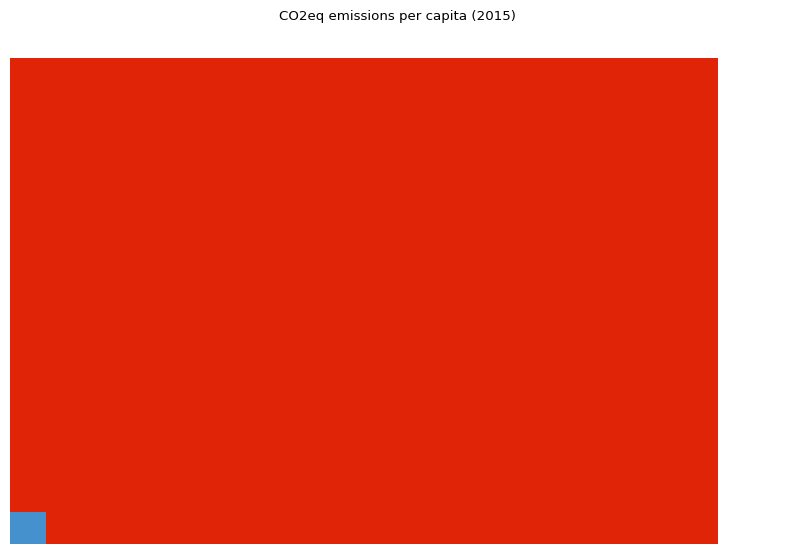

In [74]:
fig, ax = plt.subplots()

xgap = 5e6
# plt.text(x + 0.5 * row['pop'] - 4 * xgap, row['ghg_per_capita'] + ygap, row['country'], rotation=45, fontsize=9)
rec_chn = mpl.patches.Rectangle((0, 0), chn['pop'], chn['ghg_per_capita'], ec=None, fc=chn_color)
ax.add_patch(rec_chn)

svk_ghg = svk['pop'] * svk['ghg_per_capita']
svk_fake_pop = 7e7
rec_svk = mpl.patches.Rectangle((0, 0), svk_fake_pop, svk_ghg / svk_fake_pop, ec=None, fc=svk_color)
ax.add_patch(rec_svk)

ax.set(xlim=(0, 1.5e9), ylim=(0, 10))
ax.set(xlabel='Population', ylabel='t CO2eq per capita', title='CO2eq emissions per capita (2015)')
plt.axis('off')

plt.show()

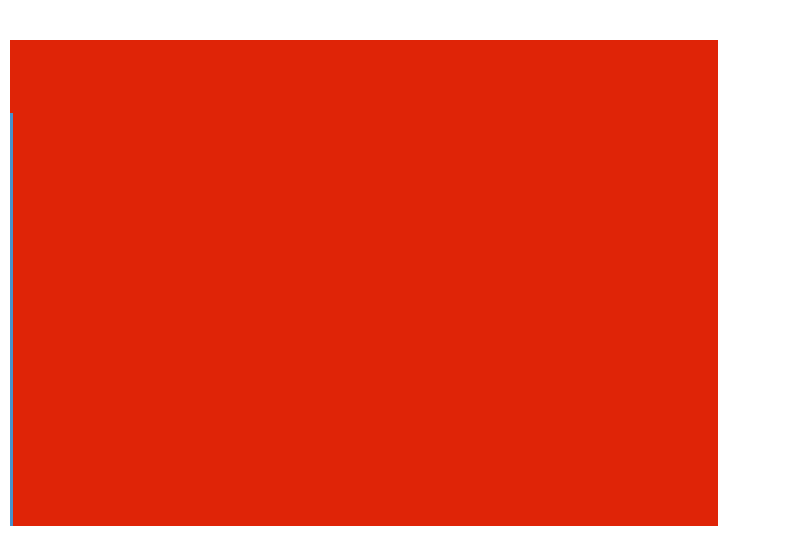

In [73]:
fig, ax = plt.subplots()

xgap = 5e6
# plt.text(x + 0.5 * row['pop'] - 4 * xgap, row['ghg_per_capita'] + ygap, row['country'], rotation=45, fontsize=9)
rec_chn = mpl.patches.Rectangle((0, 0), chn['pop'], chn['ghg_per_capita'], ec=None, fc=chn_color)
ax.add_patch(rec_chn)

svk_ghg = svk['pop'] * svk['ghg_per_capita']
svk_fake_pop = 7e7
rec_svk = mpl.patches.Rectangle((0, 0), svk['pop'], svk['ghg_per_capita'], ec=None, fc=svk_color)
ax.add_patch(rec_svk)

ax.set(xlim=(0, 1.5e9), ylim=(0, 10))
#ax.set(xlabel='Population', ylabel='t CO2eq per capita', title='CO2eq emissions per capita (2015)')
plt.axis('off')

plt.show()

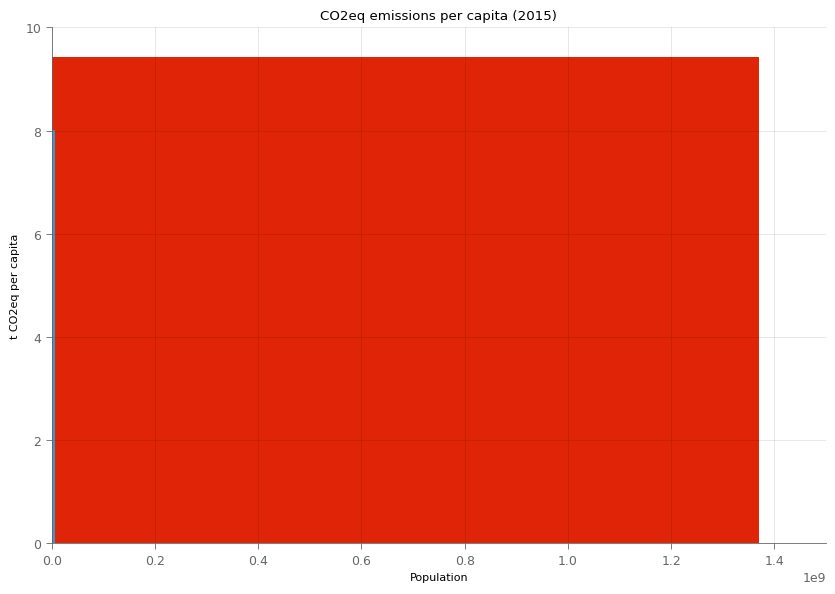

In [70]:
fig, ax = plt.subplots()

xgap = 5e6
# plt.text(x + 0.5 * row['pop'] - 4 * xgap, row['ghg_per_capita'] + ygap, row['country'], rotation=45, fontsize=9)
rec_chn = mpl.patches.Rectangle((0, 0), chn['pop'], chn['ghg_per_capita'], ec=None, fc=chn_color, alpha=1)
ax.add_patch(rec_chn)

svk_ghg = svk['pop'] * svk['ghg_per_capita']
svk_fake_pop = 7e7
rec_svk = mpl.patches.Rectangle((0, 0), svk['pop'], svk['ghg_per_capita'], ec=None, fc=svk_color)
ax.add_patch(rec_svk)

ax.set(xlim=(0, 1.5e9), ylim=(0, 10))
ax.set(xlabel='Population', ylabel='t CO2eq per capita', title='CO2eq emissions per capita (2015)')
#plt.axis('off')

plt.show()

In [19]:
svk

region                       Europe B
continent                      Europe
pop                           5423801
gdp               159750748291.707001
ghg                         43.448917
gdp_per_capita           29453.652207
ghg_per_capita               8.010787
ghg_per_gdp                271.979428
name_en                      Slovakia
name_cz                     Slovensko
Name: SVK, dtype: object

In [20]:
chn

region                            China
continent                          Asia
pop                          1371220000
gdp               17403446879536.800781
ghg                        12927.367095
gdp_per_capita             12691.943583
ghg_per_capita                 9.427639
ghg_per_gdp                  742.804985
name_en                           China
name_cz                            Čína
Name: CHN, dtype: object

In [37]:
# SVK in EU context
# - I need EU countries in alpha3 iso codes
eu_codes = ['AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL',
      'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE']

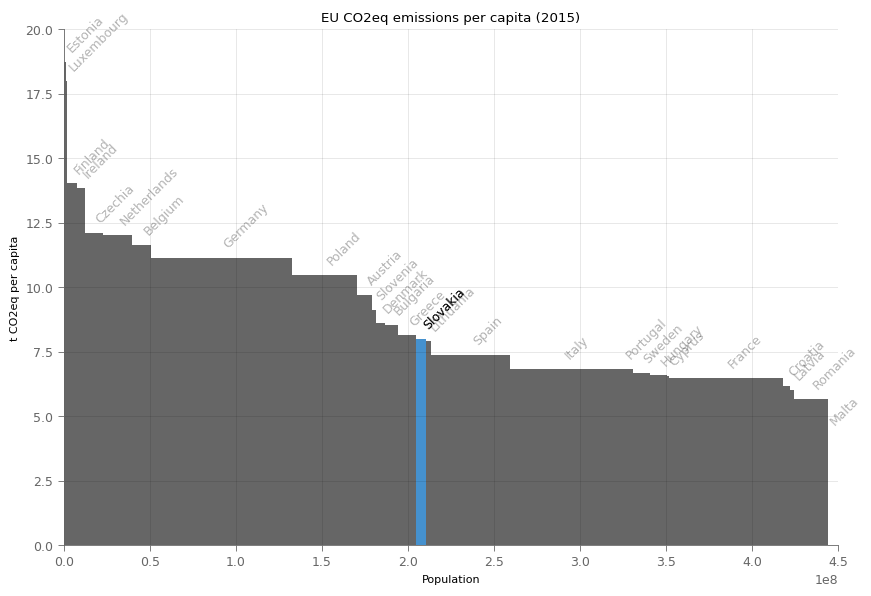

In [60]:
fig, ax = plt.subplots()

x = 0
# xgap = 2e6
xgap = 0
ygap = 0.4
eu_color = '#666666'

for i, row in df.loc[eu_codes].sort_values('ghg_per_capita', ascending=False).iterrows():
    x = x + xgap
    plt.text(x + 0.5 * row['pop'] - 4 * xgap, row['ghg_per_capita'] + ygap, row['name_en'], rotation=45, fontsize=9, alpha=0.3)
    if i == 'SVK':
        plt.text(x + 0.5 * row['pop'] - 4 * xgap, row['ghg_per_capita'] + ygap, row['name_en'], rotation=45, fontsize=9)
    rec = mpl.patches.Rectangle((x, 0), row['pop'], row['ghg_per_capita'], ec=None, fc=svk_color if i == 'SVK' else eu_color)
    ax.add_patch(rec)
    x = x + row['pop']

ax.set(xlim=(0, 4.5e8), ylim=(0, 20))
ax.set(xlabel='Population', ylabel='t CO2eq per capita', title='EU CO2eq emissions per capita (2015)')

plt.show()

In [53]:
eu = df.loc[eu_codes][['pop', 'ghg', 'gdp']].sum()
eu['gdp_per_capita'] = eu['gdp'] / eu['pop']
eu['ghg_per_capita'] = 1e6 * eu['ghg'] / eu['pop']  # in tonnes per capita
eu['ghg_per_gdp'] = 1e12 * eu['ghg'] / eu['gdp']  # in grams per dollar

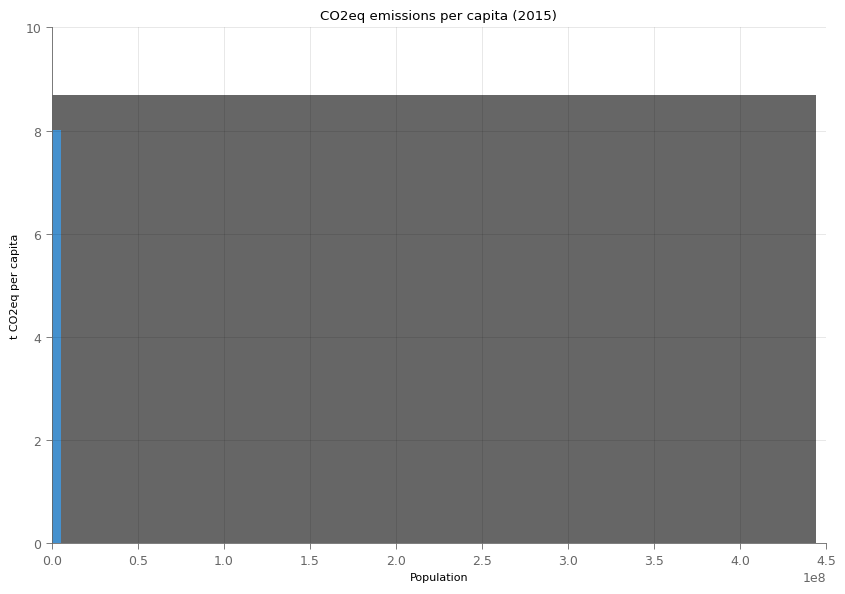

In [56]:
fig, ax = plt.subplots()

# plt.text(x + 0.5 * row['pop'] - 4 * xgap, row['ghg_per_capita'] + ygap, row['country'], rotation=45, fontsize=9)
rec_eu = mpl.patches.Rectangle((0, 0), eu['pop'], eu['ghg_per_capita'], ec=None, fc=eu_color, alpha=1)
ax.add_patch(rec_eu)
rec_svk = mpl.patches.Rectangle((0, 0), svk['pop'], svk['ghg_per_capita'], ec=None, fc=svk_color)
ax.add_patch(rec_svk)

ax.set(xlim=(0, 4.5e8), ylim=(0, 10))
ax.set(xlabel='Population', ylabel='t CO2eq per capita', title='CO2eq emissions per capita (2015)')
#plt.axis('off')

plt.show()

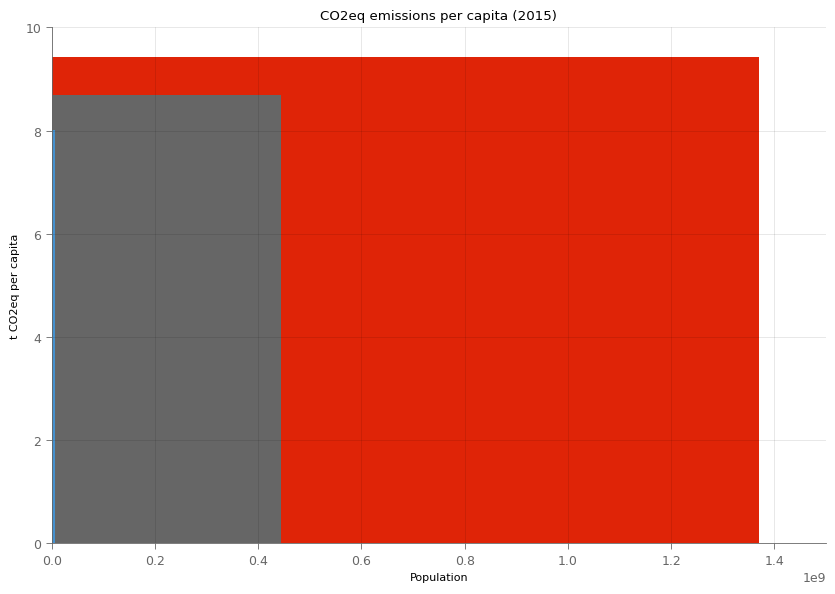

In [71]:
fig, ax = plt.subplots()

# plt.text(x + 0.5 * row['pop'] - 4 * xgap, row['ghg_per_capita'] + ygap, row['country'], rotation=45, fontsize=9)
rec_chn = mpl.patches.Rectangle((0, 0), chn['pop'], chn['ghg_per_capita'], ec=None, fc=chn_color, alpha=1)
ax.add_patch(rec_chn)
rec_eu = mpl.patches.Rectangle((0, 0), eu['pop'], eu['ghg_per_capita'], ec=None, fc=eu_color, alpha=1)
ax.add_patch(rec_eu)
rec_svk = mpl.patches.Rectangle((0, 0), svk['pop'], svk['ghg_per_capita'], ec=None, fc=svk_color)
ax.add_patch(rec_svk)

ax.set(xlim=(0, 1.5e9), ylim=(0, 10))
ax.set(xlabel='Population', ylabel='t CO2eq per capita', title='CO2eq emissions per capita (2015)')
#plt.axis('off')

plt.show()

In [48]:
df.loc[eu_codes].sort_values('ghg_per_capita', ascending=False).head()

,region,continent,pop,gdp,ghg,gdp_per_capita,ghg_per_capita,ghg_per_gdp,name_en,name_cz
code,,,,,,,,,,
EST,Europe A,Europe,1315407,4.105267e+10,24.630405,31209.097975,18.724550,599.970890,Estonia,Estonsko
LUX,Europe A,Europe,569604,6.319870e+10,10.254648,110951.988770,18.003119,162.260442,Luxembourg,Lucembursko
FIN,Europe A,Europe,5479531,2.469775e+11,76.868282,45072.747836,14.028259,311.235945,Finland,Finsko
IRL,Europe A,Europe,4701957,3.349835e+11,65.075560,71243.420871,13.840101,194.264971,Ireland,Irsko
CZE,Czechia,Europe,10546059,3.814192e+11,127.720722,36166.993162,12.110754,334.856525,Czechia,Česko


In [25]:
# SVK vs CHN GDP per capita

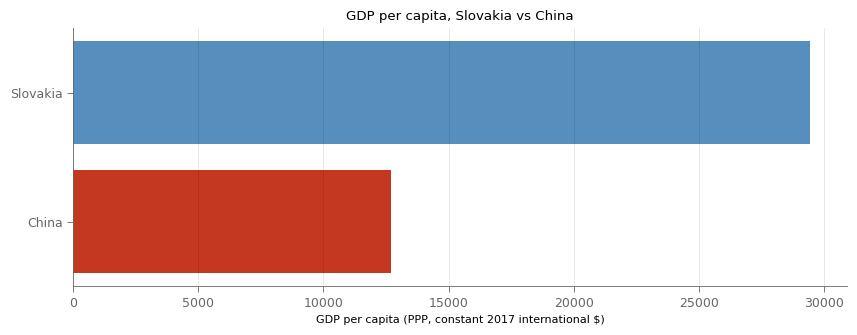

In [77]:
fig, ax = plt.subplots(figsize=(9, 3))
sns.barplot(x='gdp_per_capita', y='name_en', data=df.loc[['SVK', 'CHN']], palette=[svk_color, chn_color], ax=ax)
ax.set(xlabel='GDP per capita (PPP, constant 2017 international $)', ylabel='')
ax.set_title('GDP per capita, Slovakia vs China')
plt.show()

In [22]:
# SVK emissions embedded in trade (and comparison with China)
# - check what data is available and 